# Checking whether the second stage of AdImEx Upwind is doing the same as what is expected: FTBS

08-07-2025, Amber te Winkel

This is in order to figure out a bug within ImExRK aiUpwind version (and turns out, aiUpwind itself - also making it work with nonuniform velocity).


Output for phi = 10 initial condition, with varying_space3 velocity profile with nx=40 and dt=0.01. One time step, output after first stage (k=0) and final stage (k=1):

In [183]:
#k = 0
field_k0 = [ 9.9830678 , 10.07437401 ,10.20055643 ,10.33779394, 10.47438448 ,10.60280646,
 10.71700037, 10.81158514, 10.8818925 , 10.92440485, 10.93738817, 10.,
 10.        , 10.        , 10.        , 10.        , 10.        , 10.,
 10.        , 10.        , 10.        , 10.        , 10.        , 10.,
 10.        , 10.        , 10.        , 10.        , 10.        ,  9.20974159,
  9.21385198,  9.23325744,  9.26842911,  9.31952956,  9.38646268,  9.46889286,
  9.56623871,  9.67764555,  9.80193944,  9.90875693]

#k = 1
field_k1 = [ 9.95484747 ,10.07601016, 10.16933962, 10.2979493,  10.43757507, 10.57617903,
 10.70586024, 10.82008693, 10.91288894, 10.97886946, 11.01360737, 11.76489945,
 10.86984103, 10.80276852, 10.71592917, 10.61146128, 10.49193718, 10.36029995,
 10.21979095, 10.07386996,  9.92613004,  9.78020905,  9.63970005,  9.50806282,
  9.38853872,  9.28407083,  9.19723148,  9.13015897,  9.08450482,  9.85165162,
  9.13107121,  9.13347286,  9.15210115,  9.18683759,  9.23745725,  9.30361153,
  9.38480263,  9.48034911,  9.58934205,  9.75668513]

In [184]:
import matplotlib.pyplot as plt
import numpy as np

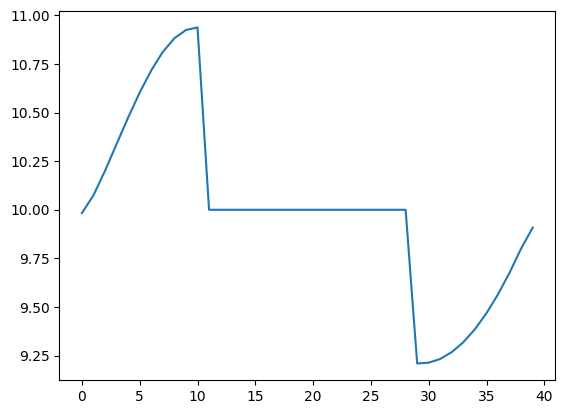

In [185]:
plt.plot(field_k0)

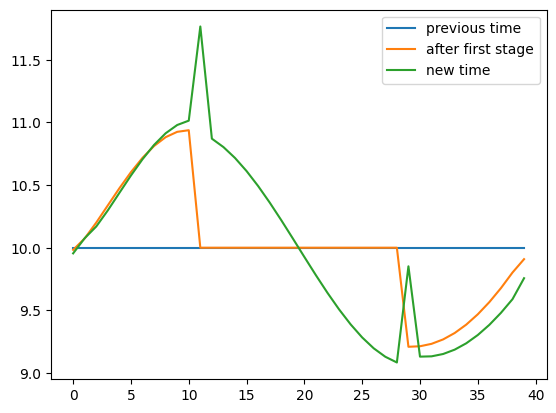

[ 9.95484749 10.07601016 10.16933961 10.2979493  10.43757507 10.57617903
 10.70586024 10.82008692 10.91288895 10.97886947 11.01360736 11.76489946
 10.86984103 10.80276852 10.71592917 10.61146128 10.49193718 10.36029995
 10.21979095 10.07386996  9.92613004  9.78020905  9.63970005  9.50806282
  9.38853872  9.28407083  9.19723148  9.13015897  9.08450482  9.85165162
  9.13107121  9.13347287  9.15210115  9.18683759  9.23745725  9.30361152
  9.38480263  9.4803491   9.58934205  9.75668513]


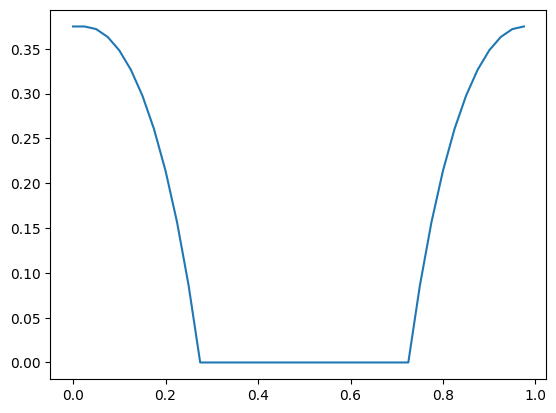

In [186]:
# Calculating FTBS by hand
def velocity_varying_space3(x, l=2.*np.pi):
    """This function returns a velocity field that is varying in space. The velocity field is given by u = 5.5 + 4.5*sin(lx), where l is a real number, default 2*pi."""
    u = 2.5 + 1.5*np.sin(l*(x + 0.25))
    
    return u

nx = len(field_k0)
field_n = np.full(nx,10.)
dxc = 0.025
dt = 0.01
xf = np.zeros(nx)
for i in range(nx-1):
    xf[i+1] = xf[i] + dxc
uf = velocity_varying_space3(xf) # i-1/2
cf = uf*dt/dxc
cc_out = 0.5*(np.abs(uf) - uf + np.abs(np.roll(uf,-1)) + np.roll(uf,-1))*dt/dxc # [i] at i, Courant defined at cell centers based on the *outward* pointing velocities
cc_in = 0.5*(np.abs(uf) + uf + np.abs(np.roll(uf,-1)) - np.roll(uf,-1))*dt/dxc # [i] at i, Courant defined at cell centers based on the *inward* pointing velocities
betac_out = np.maximum(0., 1.-1./cc_out)
betac_in = np.maximum(0., 1.-1./cc_in)
beta = np.maximum(np.maximum(betac_out, np.roll(betac_out,1)), np.maximum(betac_in, np.roll(betac_in, 1))) # [i] at i-1/2

#fieldnew = field_n - (1-beta)*dt/dxc*(np.roll(uf,-1)*field_n - uf*np.roll(field_n,1)) - beta*dt/dxc*(np.roll(uf,-1)*field_k0 - uf*np.roll(field_k0,1))
fieldnew = field_n  - dt/dxc*(np.roll(uf,-1)*field_k0 - uf*np.roll(field_k0,1))

plt.plot(field_n, label='previous time')
plt.plot(field_k0, label='after first stage')
plt.plot(fieldnew, label='new time')
plt.legend()
plt.show()

plt.plot(xf, beta)

print(fieldnew)

In [187]:
def aiUpwind(init, nt, dt, uf, dxc, solver='NumPy', niter=0):
    """This scheme test the accuracy of adaptively implicit upwind. (Needs to be first-order accurate to have a nice second/third-order correction to it.)
    Currently not upwind just FTBS - i.e. not accounting for the sign of u.
    Assuming constant velocity and dx."""
    field = np.zeros((nt+1, len(init)))
    field[0] = init.copy()

    cf = uf*dt/dxc # [i] at i-1/2
    cc_out = 0.5*(np.abs(uf) - uf + np.abs(np.roll(uf,-1)) + np.roll(uf,-1))*dt/dxc # [i] at i, Courant defined at cell centers based on the *outward* pointing velocities
    cc_in = 0.5*(np.abs(uf) + uf + np.abs(np.roll(uf,-1)) - np.roll(uf,-1))*dt/dxc # [i] at i, Courant defined at cell centers based on the *inward* pointing velocities
    betac_out = np.maximum(0., 1.-1./cc_out)
    betac_in = np.maximum(0., 1.-1./cc_in)
    beta = np.maximum(np.maximum(betac_out, np.roll(betac_out,1)), np.maximum(betac_in, np.roll(betac_in, 1))) # [i] at i-1/2

    M = np.zeros((len(init), len(init)))
    for i in range(len(init)):
        M[i,i] = 1. + beta[(i+1)%nx]*cf[(i+1)%nx]
        #M[i,(i-1)%len(init)] = -1.*beta[i]*cf[i-1] # Using this makes the artefact disappear but also makes it nonconservative
        M[i,(i-1)%len(init)] = -1.*beta[i]*cf[i] 
    
    for it in range(nt):
        #rhs = field[it] - (1-beta)*(cf*field[it] - np.roll(cf*field[it],1)) # Using this makes the artefact disappear but also makes it nonconservative
        rhs = field[it] - (np.roll(cf*(1-beta),-1)*field[it] - cf*(1-beta)*np.roll(field[it],1))
        field[it+1] = np.linalg.solve(M, rhs)
    
    return field, beta


In [188]:
field_aiU,beta = aiUpwind(field_n, 1, dt, uf, dxc)

400.0


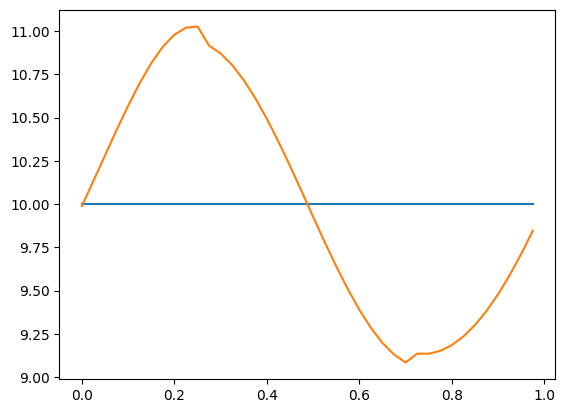

In [189]:
plt.plot(xf, field_n)
plt.plot(xf, field_aiU[-1])
print(np.sum(field_aiU[-1]))

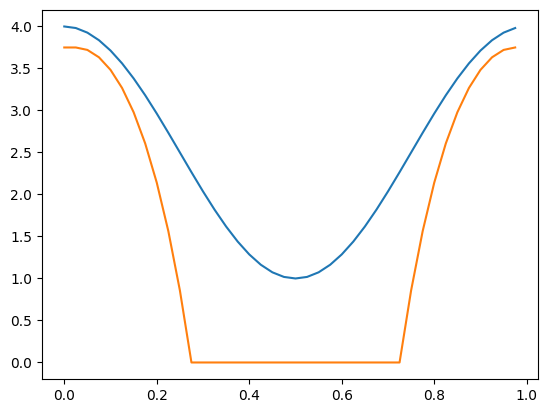

In [190]:
plt.plot(xf,uf)
plt.plot(xf,beta*10)


# Conclusion:

In [191]:
# This fixed the bug I was having in ImExRK upwind. Turns out the Butcher tableau was not defined to combine Ex and Im Upwind correctly. Apart from that, I learnt that it is indeed important for artefacts how beta and c are defined, whether on faces or on cell centres. The artefact is fully removed when beta is defined on cell centre level, but then our scheme isn't conservative. Hence, we have a small artefact at the boundary as beta needs to be defined at the faces in the end (it is calculated from cell centred values indirectly).